In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_ = pickle.load(fo, encoding='bytes')
    features = dict_[b'data'].reshape((len(dict_[b'data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = dict_[b'labels']
    return (features, labels)

In [3]:
def merge(data):
    data_ = []
    for i in range(len(data[0])):
        if data[1][i] == 2:
            data_.append(data[0][i])
    return data_

In [4]:

data = []
data_1 = unpickle('data_batch_1');
data += merge(data_1) 
data_2 = unpickle('data_batch_2');
data += merge(data_2) 
data_3 = unpickle('data_batch_3');
data += merge(data_3) 
data_4 = unpickle('data_batch_4');
data += merge(data_4) 
data_5 = unpickle('data_batch_5');
data += merge(data_5) 
test_data = unpickle('test_batch')
data += merge(test_data)

In [5]:

np.array(data).shape

(6000, 32, 32, 3)

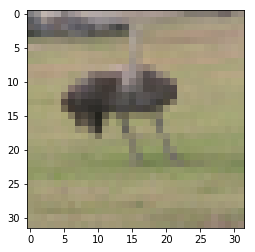

In [6]:
plt.imshow(data[5])

In [7]:
pixel_list = np.reshape(data, (6144000, 3))

In [8]:
kmeans = KMeans(n_clusters=4)

In [9]:
kmeans.fit(pixel_list)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [10]:
kmeans.cluster_centers_

array([[ 48.86643062,  49.84981537,  38.4409442 ],
       [206.34418768, 211.59303332, 211.21574834],
       [156.01265405, 155.30410647, 135.2219057 ],
       [108.69806381, 108.35577368,  82.48021122]])

In [11]:
lab = kmeans.predict(pixel_list)

In [12]:

npl = []
Y = []
for ppp in range(len(pixel_list)):
    npl.append([int(op) for op in kmeans.cluster_centers_[lab[ppp]]])
    if lab[ppp] == 0:
        Y.append([1, 0, 0, 0])
    elif lab[ppp] == 1:
        Y.append([0, 1, 0, 0])
    elif lab[ppp] == 2:
        Y.append([0, 0, 1, 0])
    elif lab[ppp] == 3:
        Y.append([0, 0, 0, 1])

In [13]:
np.shape(npl)

(6144000, 3)

In [14]:
np.shape(Y)

(6144000, 4)

In [15]:

npl = np.reshape(npl, (6000, 32, 32, 3))
Y = np.reshape(Y, (6000, 32, 32, 4))

In [16]:
from skimage.color import rgb2grey

In [17]:

X = []
pixel_list = np.reshape(pixel_list, (6000, 32, 32, 3))
for i in range(len(pixel_list)):
    X.append(rgb2grey(pixel_list[i]).tolist())
    

In [18]:
X = np.reshape(X, (6000, 32, 32, 1))

In [19]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [20]:

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D


In [21]:
model = Sequential()

In [22]:
import warnings

def warn_filter():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warn_filter()

model.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same', input_shape = (32,32,1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Conv2D(64, kernel_size = (5,5), strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
model.add(Dense(32, activation='softmax'))
model.add(Dense(4, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [23]:

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 4)         132       
Total params: 106,340
Trainable params: 106,340
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [25]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=10)

In [26]:
y_train.shape

(5400, 32, 32, 4)

In [31]:
import warnings

def warn_filter():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    warn_filter()


network = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=2)

Train on 5400 samples, validate on 600 samples
Epoch 1/30
 - 34s - loss: 0.9585 - acc: 0.6900 - val_loss: 0.9067 - val_acc: 0.6720
Epoch 2/30
 - 35s - loss: 0.8548 - acc: 0.7043 - val_loss: 0.8128 - val_acc: 0.7096
Epoch 3/30
 - 36s - loss: 0.7837 - acc: 0.7139 - val_loss: 0.7538 - val_acc: 0.7268
Epoch 4/30
 - 37s - loss: 0.7263 - acc: 0.7246 - val_loss: 0.7354 - val_acc: 0.6838
Epoch 5/30
 - 36s - loss: 0.6831 - acc: 0.7298 - val_loss: 0.6664 - val_acc: 0.7257
Epoch 6/30
 - 36s - loss: 0.6491 - acc: 0.7331 - val_loss: 0.6334 - val_acc: 0.7398
Epoch 7/30
 - 37s - loss: 0.6208 - acc: 0.7354 - val_loss: 0.6100 - val_acc: 0.7452
Epoch 8/30
 - 36s - loss: 0.5961 - acc: 0.7363 - val_loss: 0.5846 - val_acc: 0.7463
Epoch 9/30
 - 37s - loss: 0.5718 - acc: 0.7379 - val_loss: 0.5550 - val_acc: 0.7396
Epoch 10/30
 - 39s - loss: 0.5455 - acc: 0.7397 - val_loss: 0.5461 - val_acc: 0.7465
Epoch 11/30
 - 37s - loss: 0.5183 - acc: 0.7440 - val_loss: 0.5090 - val_acc: 0.7311
Epoch 12/30
 - 38s - loss: 

In [32]:
pred = model.predict(X_test)
pred = pred.reshape(614400, 4)
output_images = []
for p in range(len(pred)):
    output_images.append([int(op) for op in kmeans.cluster_centers_[np.argmax(pred[p])]])
y_test_reshaped = y_test.reshape(614400, 4)
y_test_k_color = []
for p in range(len(y_test_reshaped)):
    y_test_k_color.append([int(op) for op in kmeans.cluster_centers_[np.argmax(y_test_reshaped[p])]])
output_images = np.reshape(output_images, (600, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (600, 32, 32, 3))

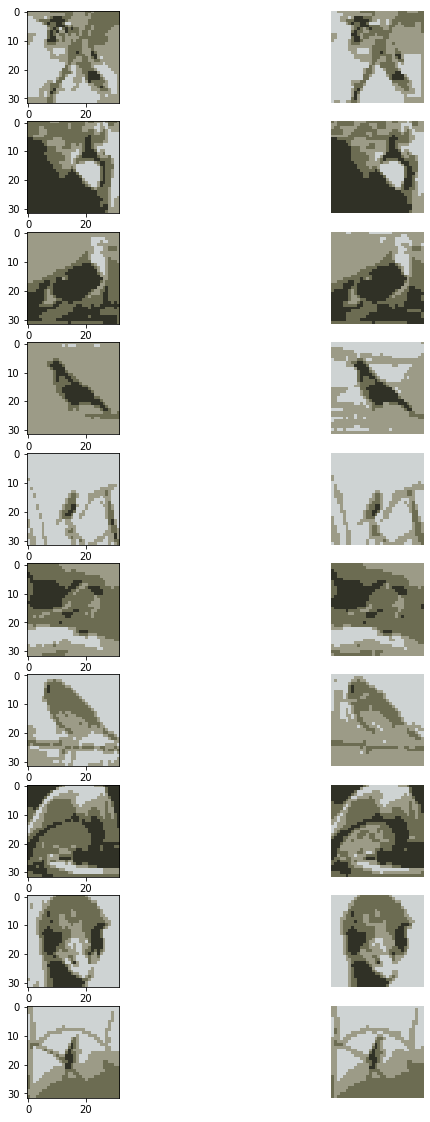

In [36]:
plt.figure(figsize=(10, 20))
subplotcount = 1
for i in range(0,10):
    plt.subplot(10, 2, subplotcount)
    subplotcount+=1
    plt.imshow(y_test_k_color[i])
    plt.subplot(10, 2, subplotcount)
    subplotcount+=1
    plt.imshow(output_images[i])
    plt.axis('off')
plt.show()

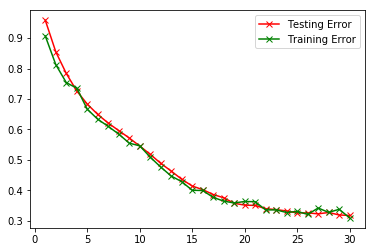

In [37]:
no_of_epochs = [int(i) for i in range(1, 31)]
plt.plot(no_of_epochs, network.history['loss'], marker = "x", color="r", label = "Testing Error")
plt.plot(no_of_epochs, network.history['val_loss'], marker = "x", color = "g", label = "Training Error")
plt.legend()